# Hub with Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/hub_with_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/hub_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/hub_with_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See [their site](https://tfhub.dev/) for a searchable listing of pre-trained models.

This tutorial provides a quick walkthrough of how to use `tfhub` with `tf.keras`.

## Setup

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

'1.12.0'

### Dataset

 For this example we'll use the TensorFlow flowers dataset: 

In [2]:
import pathlib
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

data_root = pathlib.Path(data_root)
print(data_root)

/root/.keras/datasets/flower_photos


In [0]:
IMAGE_SIZE=224

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

All of TensorFlow Hub's image modules expect input in the `[0, 1]`. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this. 

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root, target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [5]:
for image_batch,label_batch in image_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer.

In [6]:
mobilenet_layer = layers.Lambda(hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2"))
mobilenet_classifier = tf.keras.Sequential([mobilenet_layer])

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


### Run it on a batch of images

TensorFlow hub requires that you manually ititialize it's vairables. 

In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

Now run the classifier on the image batch.

In [8]:
result_batch = mobilenet_classifier.predict(image_batch)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Decode the predictions

Fetch the `ImageNet` labels, and decode the predictions

In [9]:
import numpy as np
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['bee', 'daisy', 'pot', 'artichoke', 'cardoon', 'daisy', 'daisy',
       'daisy', 'porcupine', 'brass', 'pot', 'daisy', 'quill', 'bee',
       'broom', 'daisy', 'cardoon', 'sea urchin', 'daisy', 'daisy',
       'ringlet', 'bee', 'daisy', 'picket fence', 'vase', 'stinkhorn',
       'balloon', 'pot', 'daisy', 'greenhouse', 'sea urchin', 'cardoon'],
      dtype='<U30')

Now check how these predictions line up with the images:

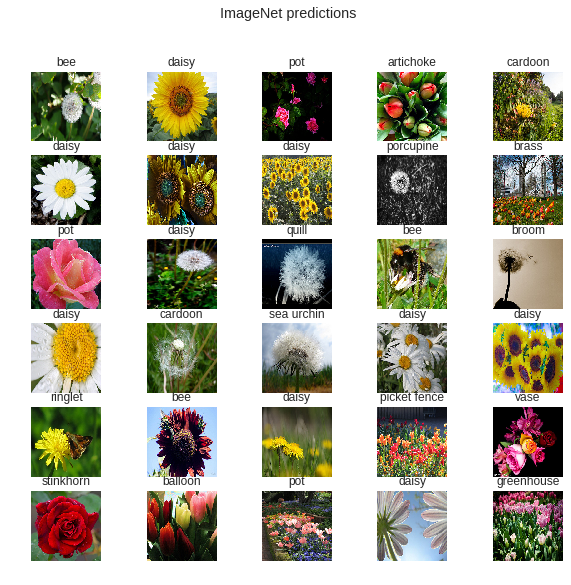

In [10]:
import matplotlib.pylab as plt

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for attributions.

The results are far from perfect, but good considering that these are not the classes the model was trained for (except "daisy").

## Simple transfer learning

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [0]:
mobilenet_features_module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2")
mobilenet_features = layers.Lambda(mobilenet_features_module)
mobilenet_features.trainable = False

Again, this this must be initialized.

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [0]:
model = tf.keras.Sequential([
  mobilenet_features,
  layers.Dense(image_data.num_classes, activation='softmax')
])

Test run a single batch, to see that the result comes back with the expected shape.

In [14]:
result = model.predict(image_batch)
result.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(32, 5)

### Train the model

Use compile to configure the training process:

In [0]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Now use the `.fit` method to train the model.

Normally you would set the number of steps per epoch, but to keep this example short we'll reain just long enough to see that the loss is reducing.

In [16]:
#steps_per_epoch=image_data.samples//image_data.batch_size)
model.fit_generator(image_data, epochs=5, steps_per_epoch=10)

Epoch 1/5
10/10 [==============================] - 5s 514ms/step - loss: 1.5872 - acc: 0.3000
Epoch 2/5
10/10 [==============================] - 1s 98ms/step - loss: 1.0482 - acc: 0.5969
Epoch 3/5
10/10 [==============================] - 1s 137ms/step - loss: 0.8062 - acc: 0.7219
Epoch 4/5
10/10 [==============================] - 2s 151ms/step - loss: 0.6195 - acc: 0.8063
Epoch 5/5
10/10 [==============================] - 2s 154ms/step - loss: 0.6430 - acc: 0.7660


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

### Decode the predictions

To redo the plot from before, first get the ordered list of class names:

In [17]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and comvert the indices to class names.

In [18]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Dandelion', 'Daisy', 'Roses', 'Tulips', 'Sunflowers', 'Daisy',
       'Sunflowers', 'Sunflowers', 'Dandelion', 'Tulips', 'Roses',
       'Dandelion', 'Dandelion', 'Dandelion', 'Dandelion', 'Daisy',
       'Dandelion', 'Dandelion', 'Daisy', 'Sunflowers', 'Dandelion',
       'Sunflowers', 'Daisy', 'Tulips', 'Roses', 'Roses', 'Tulips',
       'Tulips', 'Daisy', 'Tulips', 'Dandelion', 'Dandelion'],
      dtype='<U10')

Plot the result

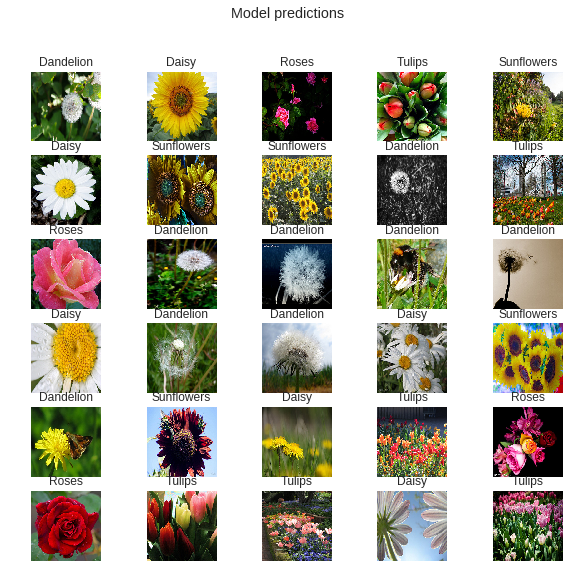

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")